# Setting up for OpenAI Gym rendering environment


> We cannot visualize the agent in notebook format, so we need to setup the environment for visualization (rendering)



In [ ]:
# For visualization (rendering OpenAI Gym)
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install ffmpeg freeglut3-dev xvfb  
!pip install -U colabgymrender

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Requirement already up-to-date: colabgymrender in /usr/local/lib/python3.7/dist-packages (1.0.9)


In [ ]:
# For visualization, must set this up to make virtual displaying screen on Colab, otherwise, it fails
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

#Import neccessary packages

In [13]:
import torch
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.distributions.categorical import Categorical
import time

# Enable GPU

In [14]:
torch.backends.cuda.matmul.allow_tf32 = True # setting default gpu for matmul on float 32 tensor
torch.backends.cudnn.allow_tf32 = True # setting default gpu for float 32 tensor
torch.set_default_tensor_type(torch.cuda.FloatTensor) # set cuda float tensor as default
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper Functions


> to_tensor: Convert Numpy to Tensor with using given size


> Avg_reward: Takes average of cumulative reward with using ratio to update the old cumulative reward


> Trajectory: It contains one episode information



> Episode_Memory: It contains rollout sets of multiple episodes in double ended que









In [15]:
def to_tensor(np_array, size=None) -> torch.tensor:
    torch_tensor = torch.from_numpy(np_array).float()
    if size is not None:
        torch_tensor = torch_tensor.view(size)
    return torch_tensor

In [16]:
class Trajectory:

    def __init__(self, gamma: float):
        self.gamma = gamma
        self.states = list()
        self.actions = list()
        self.rewards = list()
        self.next_states = list()
        self.dones = list()
        self.length = 0
        self.returns = None
        self._discounted = False

    def push(self, state, action, reward, next_state, done):
        if done and self._discounted:
            raise RuntimeError("Done occured twice. Episode currupted")

        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)
        self.length += 1

        if done and not self._discounted:
            # compute returns when done
            self.compute_return()

    def compute_return(self):
        rewards = self.rewards
        returns = list()

        g = torch.tensor(0).to(device)
        # iterating returns in reverse order
        for r in rewards[::-1]:
            g = r + self.gamma * g
            returns.insert(0, g)
        self.returns = returns
        self._discounted = True

    def get_samples(self):
        return self.states, self.actions, self.rewards, self.next_states, self.dones, self.returns

In [17]:
from collections import deque


class EpisodicMemory:

    def __init__(self, max_size: int, gamma: float):
        self.max_size = max_size  # maximum number of trajectories
        self.gamma = gamma
        self.trajectories = deque(maxlen=max_size)
        self._trajectory = Trajectory(gamma=gamma)

    def push(self, state, action, reward, next_state, done):
        self._trajectory.push(state, action, reward, next_state, done)
        if done:
            self.trajectories.append(self._trajectory)
            self._trajectory = Trajectory(gamma=self.gamma)

    def reset(self):
        self.trajectories.clear()
        self._trajectory = Trajectory(gamma=self.gamma)

    def get_samples(self):
        states, actions, rewards, next_states, dones, returns = [], [], [], [], [], []
        while self.trajectories:
            traj = self.trajectories.pop() # Pop one trajectory from memory
            s, a, r, ns, done, g = traj.get_samples()
            states.append(torch.cat(s, dim=0).to(device))
            actions.append(torch.cat(a, dim=0).to(device))
            rewards.append(torch.cat(r, dim=0).to(device))
            next_states.append(torch.cat(ns, dim=0).to(device))
            dones.append(torch.cat(done, dim=0).to(device))
            returns.append(torch.cat(g, dim=0).to(device))

        states = torch.cat(states, dim=0).to(device)
        actions = torch.cat(actions, dim=0).to(device)
        rewards = torch.cat(rewards, dim=0).to(device)
        next_states = torch.cat(next_states, dim=0).to(device)
        dones = torch.cat(dones, dim=0).to(device)
        returns = torch.cat(returns, dim=0).to(device)

        return states, actions, rewards, next_states, dones, returns


#REINFORCE AGENT

In [18]:
class REINFORCE(nn.Module):

    def __init__(self,
                policy: nn.Module,
                gamma: float = 1.0,
                lr: float = 0.0002):
      super(REINFORCE, self).__init__()
      self.policy = policy
      self.opt = torch.optim.Adam(self.policy.parameters(), lr = lr)
      self.gamma = gamma
      self._eps = 1e-25 # to prevent numbers getting to small that makes precision inaccurate

    def get_action(self, state):
      with torch.no_grad(): # avoid computing grad since we don't need while sampling action from policy
        logits = self.policy(state)
        distribution = Categorical(logits=logits) # equavlent softmax layer 
        action = distribution.sample()

      return action

    @staticmethod
    def reverse_episode(episode):
        states, actions, rewards = episode

        # reversing inputs
        states = states.flip(dims=[0]).to(device)
        actions = actions.flip(dims=[0]).to(device)
        rewards = rewards.flip(dims=[0]).to(device)
        return states, actions, rewards

    def update(self, states, actions, returns, use_norm = False):

      if use_norm: # normalizing returns
        returns = (returns - returns.mean()) / (returns.std() + self._eps)
      
  
      distribution = Categorical(logits = self.policy(states)) #generate categorical distribution using output of policy network(logits)
      prob = distribution.probs[range(states.shape[0]),actions] # calculating pi(a|s) for actions from episodes
      
      loss = (- torch.log(prob.to(device) + self._eps) * returns.squeeze()).to(device) # need to be negative since optimizer in pytorch trying 
      # to do gradient descent  to minimize loss, but we want to maximize the objective function using gradient ascent to do gradient descent 
                                             
      self.opt.zero_grad() # first need to clean out the grads
      loss = loss.mean()
      loss.backward() # computing gradient
      self.opt.step() # updating theta
      return loss


#Multi Layer Perceptron

In [2]:
class mlp(nn.Module):

    def __init__(self,
                input_dim: int,
                output_dim: int, 
                num_nureons: list,
                hidden_act: str ='ReLU', 
                output_act: str = 'Identity'):
      super(mlp,self).__init__()

      self.input_dim = input_dim
      self.input_dims = [input_dim] + num_nureons
      self.output_dim = output_dim
      self.output_dims = num_nureons + [output_dim]
      self.num_nureons = num_nureons
      self.hidden_act = getattr(nn, hidden_act)()
      self.output_act = getattr(nn, output_act)()
      self.layers = []
    

      for ind , (in_d, out_d) in enumerate(zip(self.input_dims, self.output_dims)):
        self.layers.append(nn.Linear(in_d, out_d))
        last = False
        if ind == (len(self.input_dims) - 1): # checking if it is last layer
          last = True
        else:
          last = False 

        if last: # Last layer append output activation function
          self.layers.append(self.output_act)
          self.layers = nn.Sequential(*self.layers)
        else: # For Hidden Layer append hidden activation function
          self.layers.append(self.hidden_act)

    def forward(self, x): 
      # Performs forward propagation
      out = self.layers(x)
      return out
   


## Visualizing Environment Before Training


In [ ]:
import gym
from colabgymrender.recorder import Recorder


# Setting up the environment
env = gym.make("CartPole-v1")
directory = '/content/videos'
env = Recorder(env, directory)
s_dim = env.observation_space.shape[0]
a_dim = env.action_space.n

# Setting up the network
policy_net = mlp(s_dim, a_dim, [128], 'ReLU', 'Identity').to(device)
agent = REINFORCE(policy_net).to(device)

# Run the episode without trianing
state = env.reset()
terminal = False
while not terminal:
  state = to_tensor(state, size = (1,4)).to(device)
  action = agent.get_action(state)
  next_state, reward, terminal, info = env.step(action.item())
  state = next_state

env.play()

# Using wandb to save logs
wandb is great tool for machine learning engineer that allow us to keep track of logs easily on web based format

In [ ]:
!pip install wandb
import wandb

In [ ]:
!wandb login

wandb: Currently logged in as: ko120 (use `wandb login --relogin` to force relogin)


In [ ]:
sweep_config = dict()
sweep_config['method'] = 'grid'
sweep_config['metric'] = {'name': 'cum_reward', 'goal': 'maximize'}
sweep_config['parameters'] = {'update': {'values': [2, 4, 6, 8]}}

sweep_id = wandb.sweep(sweep_config, project = 'REINFORCE_CartPole-v1')

Create sweep with ID: 1lv5d7by
Sweep URL: https://wandb.ai/ko120/REINFORCE_CartPole-v1/sweeps/1lv5d7by


In [ ]:
import pprint
pprint.pprint(sweep_config)

{'method': 'grid',
 'metric': {'goal': 'maximize', 'name': 'cum_reward'},
 'parameters': {'update': {'values': [2, 4, 6, 8]}}}


# Train the Model with REINFORCE

In [ ]:
def train():
  # initializing variables
  num_saved = 0
  num_updates = 0
  time_step = 0 
  num_eps = 4000
  print_every_eps = 500
  save_every = [500, 1000, 3000, 5000, 6000]
  avg = Avg_reward()
  ep_memory = EpisodicMemory(max_size= 100, gamma= 1.0)

  # Wandb config
  with wandb.init(config = None):
    config = wandb.config
  
    # Setting up the environment
    env = gym.make("CartPole-v1")
    s_dim = env.observation_space.shape[0]
    a_dim = env.action_space.n

    # Setting up the network
    policy_net = mlp(s_dim, a_dim, [128], 'ReLU', 'Identity').to(device)
    agent = REINFORCE(policy_net).to(device)

    wandb.watch(agent)
    start = time.time()
    for eps in range(num_eps):
      state = env.reset()
      cum_reward = 0

      while True:
        state = to_tensor(state, size = (1,4)).to(device) # turning numpy to tensor to feed it to NN
        action = agent.get_action(state) # generating action for NN
        next_state, reward, done, info = env.step(action.item()) # taking one step

        # Saving rollout datas
        reward = torch.ones(1,1).to(device)* reward
        done = torch.ones(1,1).to(device) * done
        ep_memory.push(state, action, reward, torch.tensor(next_state).float(), done)

        # updating datas
        state = next_state
        cum_reward += reward
        time_step += 1
        wandb.log({'time_step': time_step})
        # If episode ends, break
        if done:
          break

      avg.update(cum_reward) # not policy update, but averaging cumulative reward
      wandb.log({'cum_reward': avg.s, 'time_step': time_step, 'episode': eps})

      if eps % print_every_eps == 0:
        print(f'Episode {eps} Time Step {time_step}: Cumulative Avg Reward: {avg.s.item()} Time Elapsed: {time.time() - start}')
   
      # update agent
      if eps % config['update'] == 0:
        states, actions, rewards, next_states, dones, returns = ep_memory.get_samples() 
        loss = agent.update(states, actions ,returns ,use_norm= False)
        ep_memory.reset() # Must reset the memory, otherwise, it keeps original episode
        num_updates+= 1
        wandb.log({'num_updates': num_updates, 'loss': loss, 'episode': eps, 'time_step': time_step, 'cum_reward': cum_reward})
      # save agent
      if eps == save_every[num_saved]:
        save_name = 'policy_net_' + str(eps) + '_update_every' +str(config['update']) + '.pt'
        torch.save(policy_net.state_dict(),save_name)
        num_saved += 1
        wandb.save(save_name)

    
    # Saving Final agent
    save_name = 'policy_net_final' + '_update_every' + str(config['update']) + '.pt'
    torch.save(policy_net.state_dict(), save_name)
    wandb.save('./policy_net_final.pt')
    print(f'Ended at: {time.time() - start}')

# Run the Sweep

In [ ]:
sweep_config = dict()
sweep_config['method'] = 'grid'
sweep_config['metric'] = {'name': 'cum_reward', 'goal': 'maximize'}
sweep_config['parameters'] = {'update': {'values': [2, 4, 6, 8]}}

sweep_id = wandb.sweep(sweep_config, project = 'REINFORCE_CartPole-v1_update_variation')

wandb.agent(sweep_id,train) # passing the train function without putting '()'

wandb: Agent Starting Run: u6iv14jo with config:
wandb: 	update: 2
wandb: Currently logged in as: ko120 (use `wandb login --relogin` to force relogin)


Episode 0 Time Step 17: Cumulative Avg Reward: 17.0 Time Elapsed: 0.08988547325134277
Episode 500 Time Step 15995: Cumulative Avg Reward: 40.423282623291016 Time Elapsed: 78.90008425712585
Episode 1000 Time Step 40032: Cumulative Avg Reward: 46.54029846191406 Time Elapsed: 194.2707223892212
Episode 1500 Time Step 84667: Cumulative Avg Reward: 125.79515075683594 Time Elapsed: 405.5132179260254
Episode 2000 Time Step 162568: Cumulative Avg Reward: 163.65615844726562 Time Elapsed: 771.6817784309387
Episode 2500 Time Step 283253: Cumulative Avg Reward: 302.1192321777344 Time Elapsed: 1338.786286354065
Episode 3000 Time Step 438957: Cumulative Avg Reward: 439.26861572265625 Time Elapsed: 2069.5611255168915
Episode 3500 Time Step 619525: Cumulative Avg Reward: 311.46575927734375 Time Elapsed: 2918.5834534168243


wandb: Ctrl + C detected. Stopping sweep.


# You can check out the result on this page
https://wandb.ai/ko120/REINFORCE_CartPole-v1_update_variation?workspace=user-ko120

We can observe that batch episode update is not sample efficient

# Visualize Trained Agent

# 500 Episode trained

In [ ]:
policy_net = mlp(s_dim, a_dim, [128], 'ReLU', 'Identity').to(device)
agent = REINFORCE(policy_net).to(device)
avg = Avg_reward()
policy_net.load_state_dict(torch.load('policy_net_500.pt'))
policy_net.eval() # Must turn this into eval mode before use
agent.eval()

In [ ]:
import gym
from colabgymrender.recorder import Recorder

env = gym.make("CartPole-v1")
directory = '/content/videos'

env = Recorder(env, directory)

state = env.reset()
terminal = False
while not terminal:
  state = to_tensor(state, size = (1,4))
  action = agent.get_action(state)
  next_state, reward, terminal, info = env.step(action.item())
  state = next_state

env.play()

# 1000 Episode Trained

In [ ]:
policy_net = mlp(s_dim, a_dim, [128], 'ReLU', 'Identity').to(device)
agent = REINFORCE(policy_net).to(device)
avg = Avg_reward()
policy_net.load_state_dict(torch.load('policy_net_1000.pt'))
policy_net.eval() # Must turn this into eval mode before use
agent.eval()

In [ ]:
import gym
from colabgymrender.recorder import Recorder

env = gym.make("CartPole-v1")
directory = '/content/videos'

env = Recorder(env, directory)

state = env.reset()
terminal = False
while not terminal:
  state = to_tensor(state, size = (1,4))
  action = agent.get_action(state)
  next_state, reward, terminal, info = env.step(action.item())
  state = next_state

env.play()

#3000 Episode Trained

In [ ]:
policy_net = mlp(s_dim, a_dim, [128], 'ReLU', 'Identity').to(device)
agent = REINFORCE(policy_net).to(device)
avg = Avg_reward()
policy_net.load_state_dict(torch.load('policy_net_3000.pt'))
policy_net.eval() # Must turn this into eval mode before use
agent.eval()

In [ ]:
import gym
from colabgymrender.recorder import Recorder

env = gym.make("CartPole-v1")
directory = '/content/videos'

env = Recorder(env, directory)

state = env.reset()
terminal = False
while not terminal:
  state = to_tensor(state, size = (1,4))
  action = agent.get_action(state)
  next_state, reward, terminal, info = env.step(action.item())
  state = next_state

env.play()

#Fully Trained Agent

In [ ]:
policy_net = mlp(s_dim, a_dim, [128], 'ReLU', 'Identity').to(device)
agent = REINFORCE(policy_net).to(device)
avg = Avg_reward()
policy_net.load_state_dict(torch.load('policy_net_5000.pt'))
policy_net.eval() # Must turn this into eval mode before use
agent.eval()

REINFORCE(
  (policy): mlp(
    (hidden_act): ReLU()
    (output_act): Identity()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=2, bias=True)
      (3): Identity()
    )
  )
)

In [ ]:
import gym
from colabgymrender.recorder import Recorder

env = gym.make("CartPole-v1")
directory = '/content/videos'

env = Recorder(env, directory)

state = env.reset()
terminal = False
while not terminal:
  state = to_tensor(state, size = (1,4))
  action = agent.get_action(state)
  next_state, reward, terminal, info = env.step(action.item())
  state = next_state

env.play()

# Plotting the learning curve

In [ ]:
from matplotlib import pyplot as plt

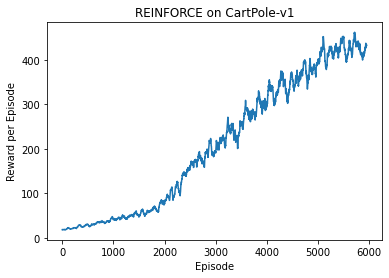

In [ ]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')
  
averaged_reward_eps = moving_average(reward_eps,50)
plt.plot(list(range(len(averaged_reward_eps))),averaged_reward_eps)
plt.ylabel('Reward per Episode')
plt.xlabel('Episode')
plt.title('REINFORCE on CartPole-v1')
plt.show()

# Load the model

In order to load the model, we need to re-make policy network and learning agent since it just load learned parameters(theta) to the model

In [ ]:
policy_net = mlp(state_space_dim, action_space_dim, [128], 'ReLU', 'Identity').to(device)
agent = REINFORCE(policy_net).to(device)
avg = Avg_reward()

In [ ]:
policy_net.state_dict()

In [ ]:
policy_net.load_state_dict(torch.load('policy_net.pt'))

In [ ]:
policy_net.state_dict()

Important point here is that we need set the agent to eval mode to use this model!

In [ ]:
policy_net.eval()
agent.eval()